In [1]:
import numpy as np
import pandas as pd

In [2]:
INPUT_PATH = './Data/csv/'
OUTPUT_PATH = './Data/features/'

list_of_seasons = ['1213', '1314']
list_of_leagues = ['EPL', 'LL']

data_list = []
for season in list_of_seasons:
    for league in list_of_leagues:
        tmp_df = pd.read_csv((INPUT_PATH + "shots_{}{}.csv".format(league, season)), header=None, names=['league','season',
                             'homeTeam','awayTeam','date','team','min','sec','x','y','goalYN',
                             'state','headerYN','bigChanceYN','fromCornerYN','fastBreakYN',
                             'penaltyYN','directFKYN','ownGoalYN','chanceX1','chanceY1',
                             'chanceX2','chanceY2','crossYN','throughballYN','indirectFKYN',
                             'secondThroughballYN','dribbleKeeperYN','dribbleBeforeYN','reboundYN',
                             'errorYN','onTarget','sixYard','penaltyArea','outBox'])
        data_list.append(tmp_df)
        
raw_df = pd.concat(data_list, axis=0)

In [3]:
raw_df.head()

,league,season,homeTeam,awayTeam,date,team,min,sec,x,y,...,indirectFKYN,secondThroughballYN,dribbleKeeperYN,dribbleBeforeYN,reboundYN,errorYN,onTarget,sixYard,penaltyArea,outBox
0,Premier League,2012/2013,Arsenal,Wigan,14/05/2013,Arsenal,0,59,86.0,27.3,...,0,0,0,0,0,0,0,0,1,0
1,Premier League,2012/2013,Arsenal,Wigan,14/05/2013,Arsenal,6,23,88.5,48.0,...,0,0,0,0,0,0,0,0,1,0
2,Premier League,2012/2013,Arsenal,Wigan,14/05/2013,Arsenal,10,18,95.8,50.0,...,0,0,0,0,0,0,1,1,0,0
3,Premier League,2012/2013,Arsenal,Wigan,14/05/2013,Arsenal,14,24,73.2,44.3,...,0,0,0,0,0,0,0,0,0,1
4,Premier League,2012/2013,Arsenal,Wigan,14/05/2013,Arsenal,17,28,74.6,27.4,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# remove columns which won't be used in model:
data_df = raw_df.drop(['season', 'homeTeam', 'awayTeam', 'date', 'team', 'min', 'sec', 'chanceX1', 'chanceY1', 'chanceX2', 
              'chanceY2','onTarget', 'sixYard', 'penaltyArea', 'outBox', 'penaltyYN', 'ownGoalYN'], axis=1)

## Pre-Processing/ Feature Engineering:

In [5]:
# one-hot encoding for league feature:
dummy_league = pd.get_dummies(data_df['league'])
data_df.drop(['league'], axis=1, inplace=True)

In [6]:
data_df = pd.concat([data_df, dummy_league], axis=1)

In [7]:
data_df['state'].hist()

In [93]:
# clip shot 'state' (whether a team is ahead, equal or behind to the other team)
data_df['state'] = data_df['state'].apply(lambda x: 1 if x >= 1 else (-1 if x <= -1 else 0))

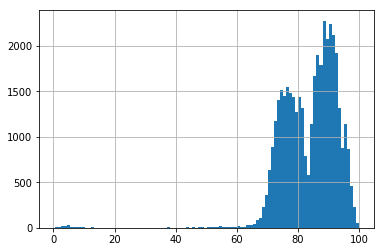

In [94]:
data_df['x'].hist(bins=100)

In [8]:
data_df['x'] = 100 - data_df['x']

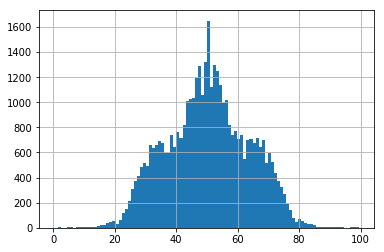

In [9]:
data_df['y'].hist(bins=100)

In [10]:
# distance to the centre of the goal posts:
data_df['distance'] = np.sqrt(data_df['x']**2 + (50 - data_df['y'])**2)

In [11]:
data_df['distance'].describe()

count    40286.000000
mean        20.786847
std          9.822764
min          0.781025
25%         13.231024
50%         20.938481
75%         27.201838
max        104.822612
Name: distance, dtype: float64

In [12]:
# angle of goals seen:
import math

for index, row in data_df[['x','y', 'distance']].iterrows():
    if row['y'] <= 44.3:
        if row['x'] != 0:
            b = 44.3 - row['y']
            c = 55.7 - row['y']
            angle = math.degrees(math.atan(c/row['x']) - math.atan(b/row['x']))
        else:
            angle = 0
    elif row['y'] >= 55.7:
        if row['x'] != 0:
            b = row['y'] - 55.7
            c = row['y'] - 44.3
            angle = math.degrees(math.atan(c/row['x']) - math.atan(b/row['x']))
        else:
            angle = 0
    else:
        if row['x'] != 0:
            d = row['y'] - 44.3
            e = 55.7 - row['y']
            angle = math.degrees(math.atan(d/row['x']) + math.atan(e/row['x']))
        else:
            angle = 180
    data_df.loc[index, 'angle'] = angle

In [13]:
data_df.head()

,x,y,goalYN,state,headerYN,bigChanceYN,fromCornerYN,fastBreakYN,directFKYN,crossYN,...,indirectFKYN,secondThroughballYN,dribbleKeeperYN,dribbleBeforeYN,reboundYN,errorYN,La Liga,Premier League,distance,angle
0,14.0,27.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,26.670021,20.952716
1,11.5,48.0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,11.672618,25.026765
2,4.2,50.0,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,4.200000,20.570460
3,26.8,44.3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,27.399453,33.318506
4,25.4,27.4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,33.998824,40.383749


In [14]:
# split dataframe into subtypes:
direct_df = data_df[data_df['directFKYN']==1]
head_cross_df = data_df[(data_df['headerYN']==1) & (data_df['crossYN']==1)]
cross_df = data_df[(data_df['headerYN']==0) & (data_df['crossYN']==1)]
head_df = data_df[(data_df['headerYN']==1) & (data_df['crossYN']==0)]
regular_df = data_df[(data_df['headerYN']==0) & (data_df['crossYN']==0) & (data_df['directFKYN']==0)]

In [15]:
# save as csv's:
direct_df.to_csv(OUTPUT_PATH + 'direct_df.csv')
head_cross_df.to_csv(OUTPUT_PATH + 'head_cross_df.csv')
cross_df.to_csv(OUTPUT_PATH + 'cross_df.csv')
head_df.to_csv(OUTPUT_PATH + 'head_df.csv')
regular_df.to_csv(OUTPUT_PATH + 'regular_df.csv')